# Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar


# Data Preparation

Note that by now there exists separat data cleaning on a different branch which is probably redundant with the preparation here. We will have to see what to do when we merge. 

In [2]:
bike_df = pd.read_csv('data/bike_data.csv')  # read bike data

# set options to display more rows & columns of dataframes
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)


c:\Users\dawae\miniconda3\envs\AA_Team12\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (18,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# convert date feature to pd Datetime objects
bike_df['datetime'] = pd.to_datetime(bike_df['datetime'])


In [4]:
# only data from 2019 relevant, in our raw data we also have data from 2020 (and potentially miss the first days od 2019)
bike_df = bike_df[bike_df['datetime'].dt.year == 2019]


# Analysis

Here we look for and show summary statistics and patterns in the data, primarily in the form of plots.

### Total number of trips

In [5]:
trip_df = pd.read_csv("data/trip.csv")
trip_df["end_time"] = pd.to_datetime(trip_df["end_time"])
trip_df["start_time"] = pd.to_datetime(trip_df["start_time"])
trip_df["day"] = pd.to_datetime(trip_df["day"])


In [6]:
print(f'Total number of trips in 2019: {len(trip_df)}')
print(
    f'Average number of trips per day: {trip_df.groupby("day")["bike_id"].count().mean():.1f}')
print(
    f'Maximum number of trips per day: {trip_df.groupby("day")["bike_id"].count().max()}')
print(
    f'Average trip duration: {((trip_df["end_time"]-trip_df["start_time"]).dt.seconds / 60.0).mean():.2f}')
print(
    f'Maximum trip duration: {((trip_df["end_time"]-trip_df["start_time"]).dt.seconds / 60.0).max()}')


Total number of trips in 2019: 444854
Average number of trips per day: 1225.5
Maximum number of trips per day: 2516
Average trip duration: 22.11
Maximum trip duration: 600.0


### Trips by date

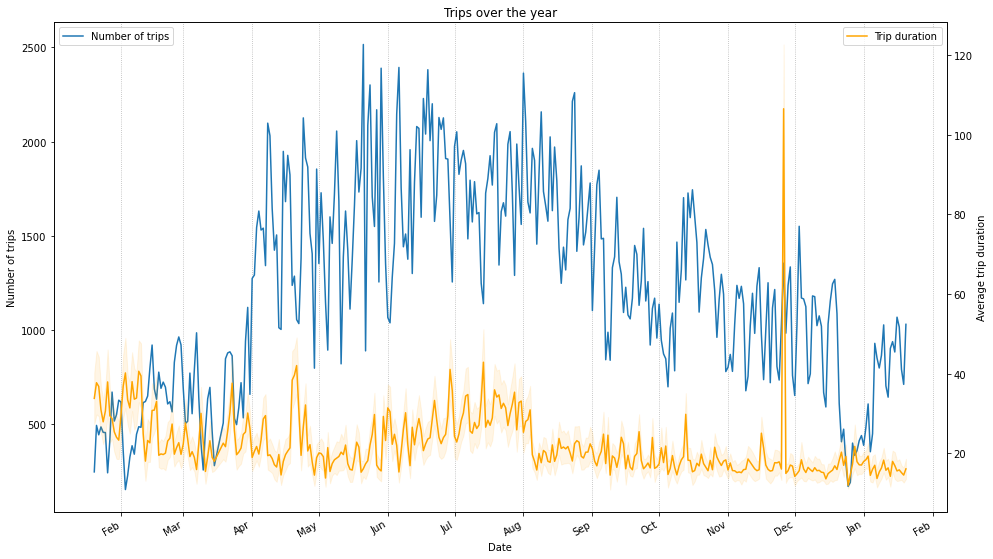

In [7]:
# Plot trip numbers and duration over the course of the year
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Trips over the year')
ax2 = ax.twinx()  # second y axis for duration
trip_df.groupby('day')['bike_id'].count().reset_index().plot(
    ax=ax, x='day', y='bike_id', legend=True)
trip_df.groupby('day')['duration'].mean().reset_index().plot(
    ax=ax2, x='day', y='duration', c='orange', legend=True)

# for depicting std of duration
df1 = trip_df.groupby('day')['duration'].mean(
).reset_index().sort_values('day')
df2 = trip_df.groupby('day')['duration'].std().reset_index().sort_values('day')
ax2.fill_between(df1['day'], df1['duration']-df2['duration']/10,
                 df1['duration']+df2['duration']/10, color='orange', alpha=.1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_xlabel('Date')
ax.set_ylabel('Number of trips')
ax2.set_ylabel('Average trip duration')
ax.xaxis.grid(linestyle=':')
ax.legend(labels=['Number of trips'], loc='upper left')
ax2.legend(labels=['Trip duration'])
plt.show()


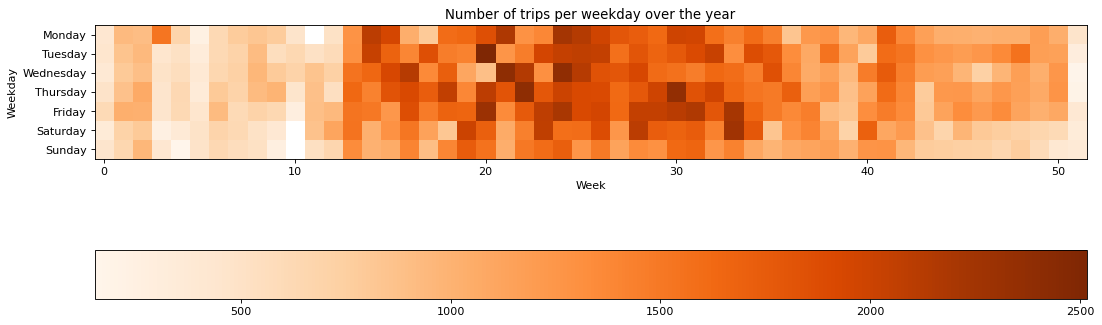

In [8]:
# plot trips per weekday over the course of the year
df = trip_df.groupby('day')['bike_id'].count().reset_index()
df['week'] = df['day'].dt.isocalendar().week
df['weekday'] = df['day'].dt.dayofweek
df = df.groupby(['week', 'weekday'])['bike_id'].sum().unstack().transpose()
df = df.rename(dict(zip(list(range(7)), list(calendar.day_name))), axis=0)
plt.figure(figsize=(16, 10), dpi=80)
plt.title('Number of trips per weekday over the year')
plt.xlabel('Week')
plt.yticks(np.arange(7), list(calendar.day_name))
plt.ylabel('Weekday')
plt.imshow(df, cmap='Oranges', interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.show()


### Trips by weekday

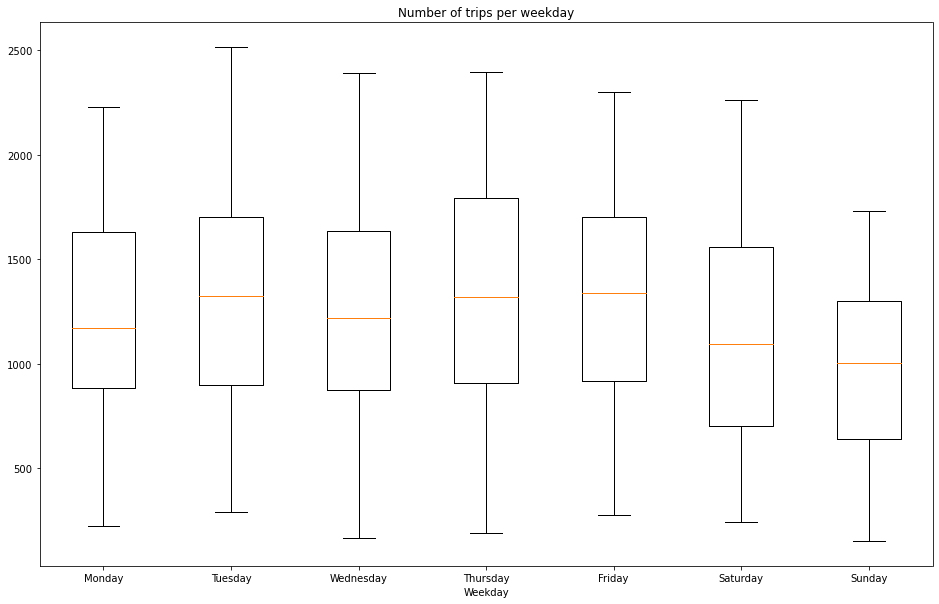

In [9]:
# compute boxplots for trip numbers per weekday
df = trip_df.groupby('day')['bike_id'].count().reset_index()
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Number of trips per weekday')
data = [df['bike_id'][df['day'].dt.weekday == i] for i in range(7)]
ax.boxplot(data, labels=list(calendar.day_name))
ax.set_xlabel('Weekday')
plt.show()


### Trips by time of day

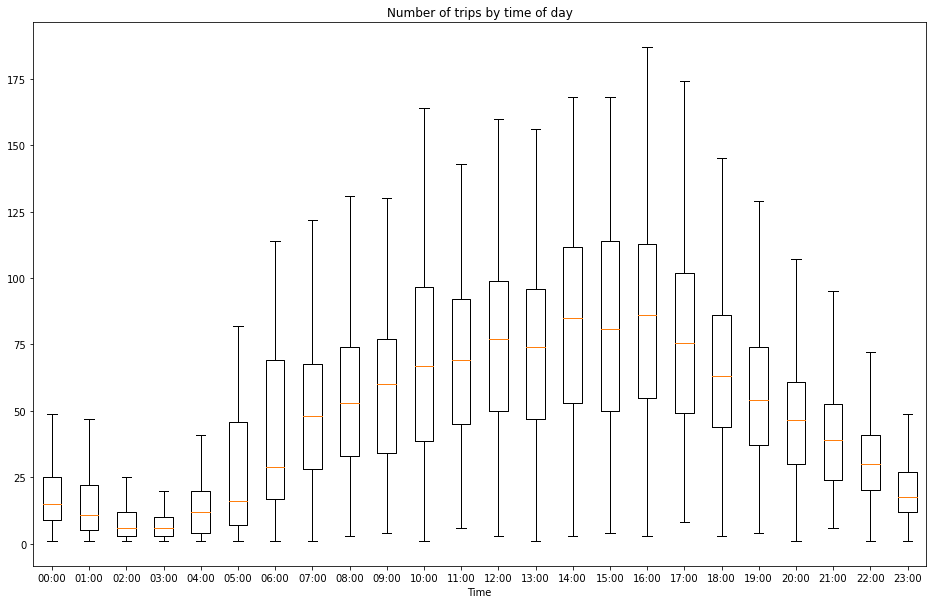

In [10]:
df = trip_df.groupby(['day', 'hour'])['bike_id'].count().reset_index()
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Number of trips by time of day')
data = [df[df['hour'] == i]['bike_id'] for i in range(24)]
ax.boxplot(data, labels=[f'{i:02d}:00' for i in range(24)], showfliers=False)
ax.set_xlabel('Time')
plt.show()


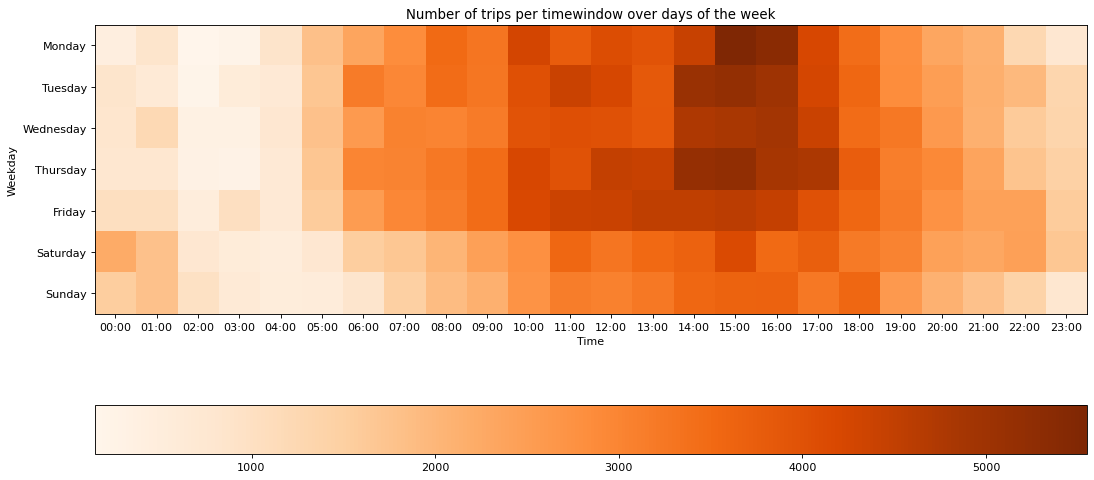

In [11]:
df = trip_df.groupby(['weekday', 'hour'])['bike_id'].count().unstack()
plt.figure(figsize=(16, 10), dpi=80)
plt.title('Number of trips per timewindow over days of the week')
plt.xlabel('Time')
plt.xticks(np.arange(24), [f'{i:02d}:00' for i in range(24)])
plt.yticks(np.arange(7), list(calendar.day_name))
plt.ylabel('Weekday')
plt.imshow(df, cmap='Oranges', interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.show()


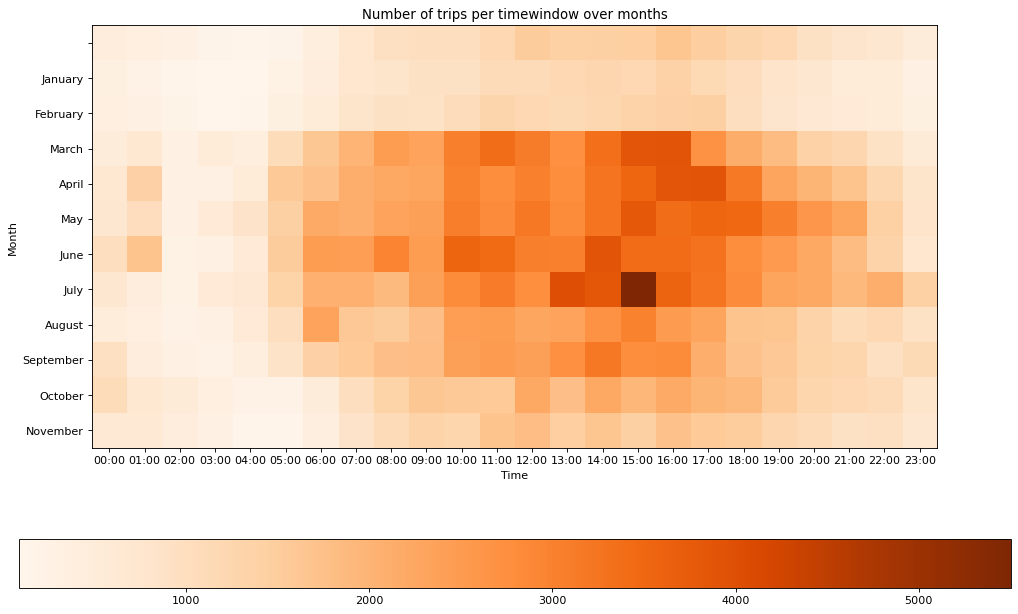

In [12]:
df = trip_df.groupby(['month', 'hour'])['bike_id'].count().unstack()
plt.figure(figsize=(16, 10), dpi=80)
plt.title('Number of trips per timewindow over months')
plt.xlabel('Time')
plt.xticks(np.arange(24), [f'{i:02d}:00' for i in range(24)])
plt.yticks(np.arange(13), list(calendar.month_name))
plt.ylabel('Month')
plt.imshow(df, cmap='Oranges', interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.show()


### Trip duration

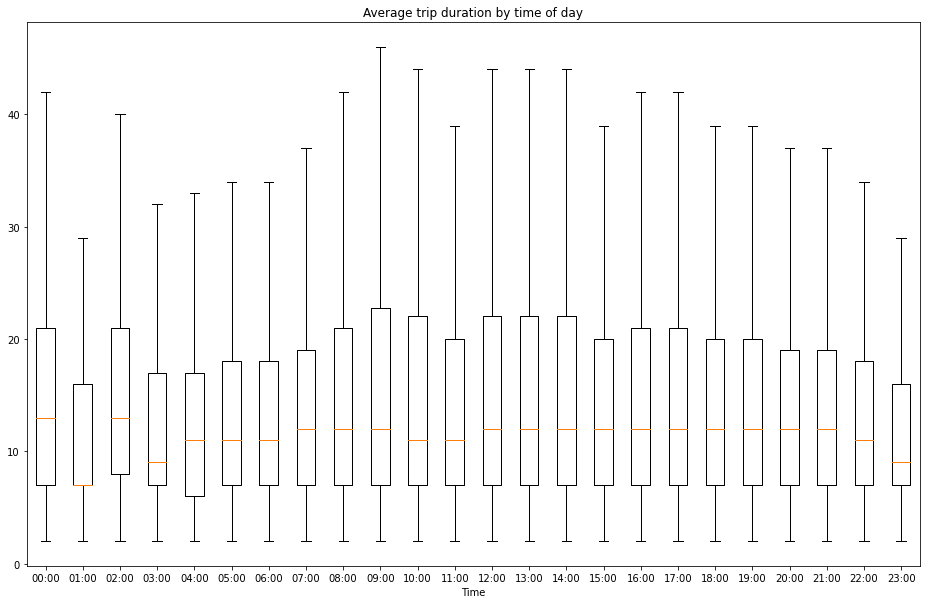

In [13]:
df = trip_df[['hour', 'duration']]
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Average trip duration by time of day')
data = [df[df['hour'] == i]['duration'] for i in range(24)]
ax.boxplot(data, labels=[f'{i:02d}:00' for i in range(24)], showfliers=False)
ax.set_xlabel('Time')
plt.show()


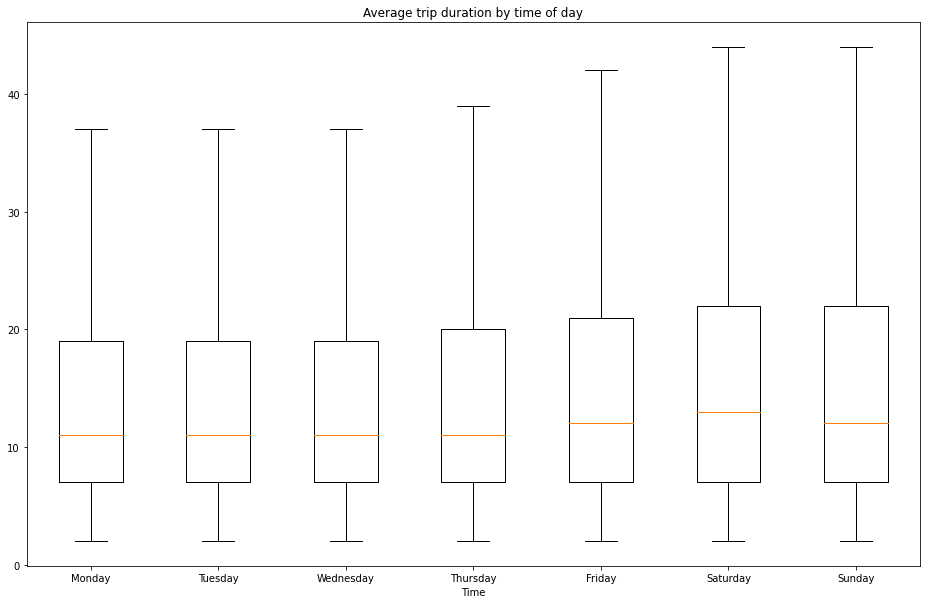

In [14]:
df = trip_df[['weekday', 'duration']]
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Average trip duration by time of day')
data = [df[df['weekday'] == i]['duration'] for i in range(7)]
ax.boxplot(data, labels=list(calendar.day_name), showfliers=False)
ax.set_xlabel('Time')
plt.show()


## Weather

### Temperature

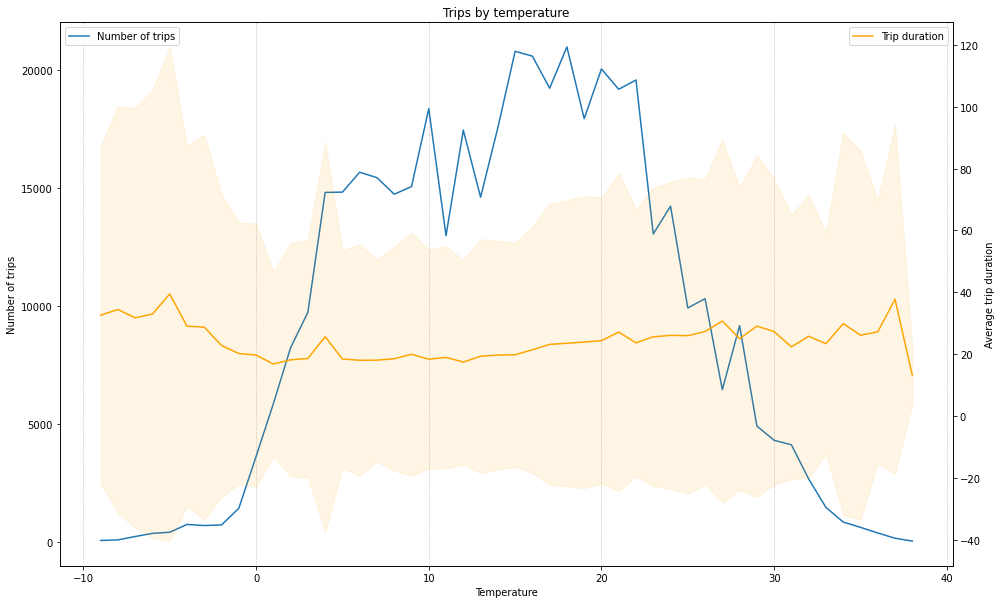

In [15]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Trips by temperature')
ax2 = ax.twinx()
df = trip_df.copy()
df.loc[:, 'temperature'] = df['temperature'].apply(round)
df.groupby('temperature')['bike_id'].count().reset_index().plot(
    ax=ax, x='temperature', y='bike_id', legend=True)
df.groupby('temperature')['duration'].mean().reset_index().plot(
    ax=ax2, x='temperature', y='duration', c='orange', alpha=1, legend=True)
df1 = df.groupby('temperature')['duration'].mean(
).reset_index().sort_values('temperature')
df2 = df.groupby('temperature')['duration'].std(
).reset_index().sort_values('temperature')
ax2.fill_between(df1['temperature'], df1['duration']-df2['duration'],
                 df1['duration']+df2['duration'], color='orange', alpha=.1)
ax.set_xlabel('Temperature')
ax.set_ylabel('Number of trips')
ax2.set_ylabel('Average trip duration')
ax.xaxis.grid(linestyle=':')
ax.legend(labels=['Number of trips'], loc='upper left')
ax2.legend(labels=['Trip duration'])
plt.show()


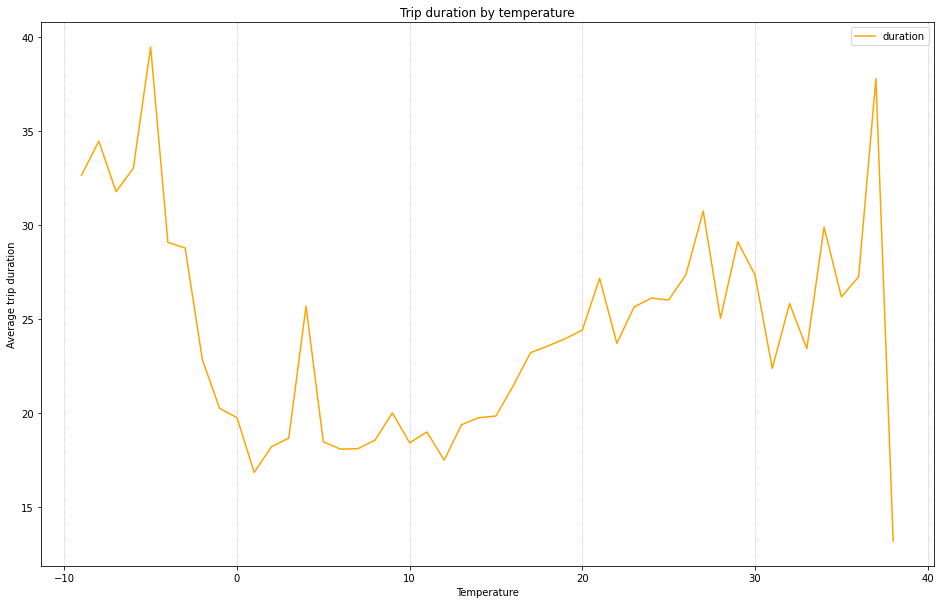

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Trip duration by temperature')
df = trip_df.copy()
df.loc[:, 'temperature'] = df['temperature'].apply(round)
df.groupby('temperature')['duration'].mean().reset_index().plot(
    ax=ax, x='temperature', y='duration', c='orange', alpha=1, legend=True)
ax.set_xlabel('Temperature')
ax.set_ylabel('Average trip duration')
ax.xaxis.grid(linestyle=':')
plt.show()


### Wind

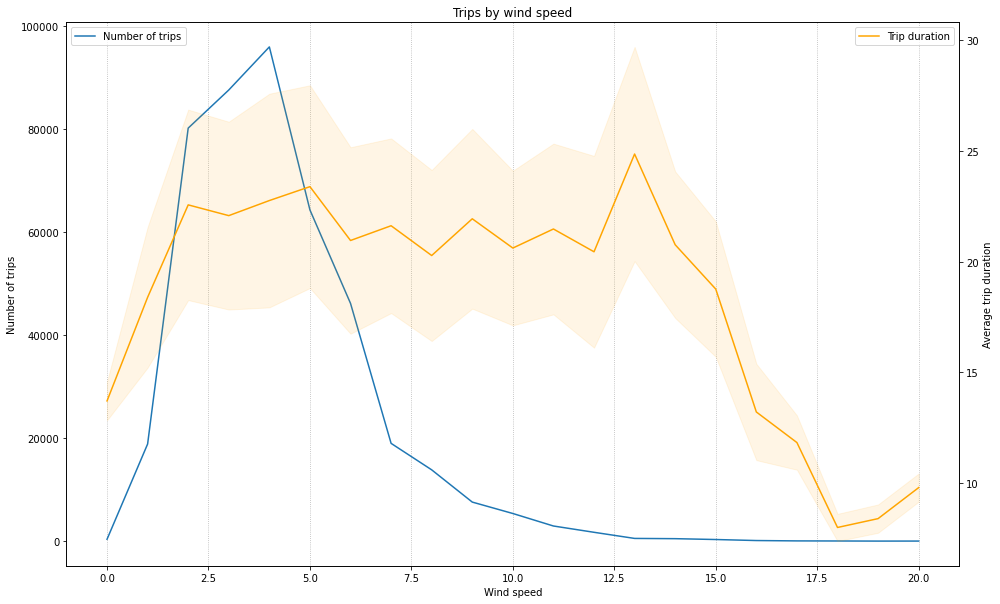

In [17]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Trips by wind speed')
ax2 = ax.twinx()
df = trip_df.copy()
df.loc[:, 'wind'] = df['wind'].apply(round)
df.groupby('wind')['bike_id'].count().reset_index().plot(
    ax=ax, x='wind', y='bike_id', legend=True)
df.groupby('wind')['duration'].mean().reset_index().plot(
    ax=ax2, x='wind', y='duration', c='orange', alpha=1, legend=True)
df1 = df.groupby('wind')['duration'].mean().reset_index().sort_values('wind')
df2 = df.groupby('wind')['duration'].std().reset_index().sort_values('wind')
ax2.fill_between(df1['wind'], df1['duration']-df2['duration']/10,
                 df1['duration']+df2['duration']/10, color='orange', alpha=.1)
ax.set_xlabel('Wind speed')
ax.set_ylabel('Number of trips')
ax2.set_ylabel('Average trip duration')
ax.xaxis.grid(linestyle=':')
ax.legend(labels=['Number of trips'], loc='upper left')
ax2.legend(labels=['Trip duration'])
plt.show()


### Rain

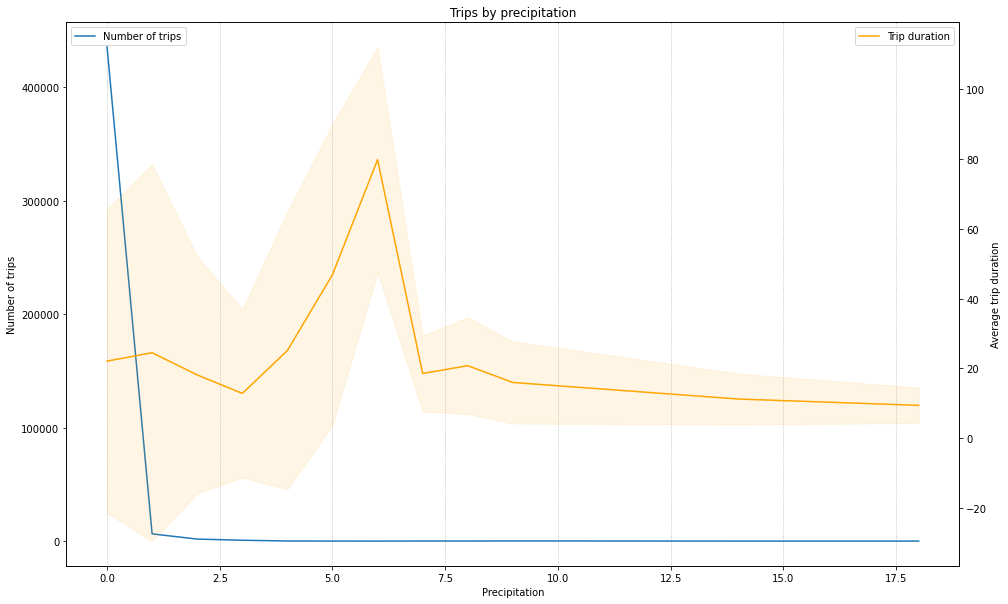

In [18]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Trips by precipitation')
ax2 = ax.twinx()
df = trip_df.copy()
df.loc[:, 'rain'] = df['rain'].apply(round)
df.groupby('rain')['bike_id'].count().reset_index().plot(
    ax=ax, x='rain', y='bike_id', legend=True)
df.groupby('rain')['duration'].mean().reset_index().plot(
    ax=ax2, x='rain', y='duration', c='orange', alpha=1, legend=True)
df1 = df.groupby('rain')['duration'].mean().reset_index().sort_values('rain')
df2 = df.groupby('rain')['duration'].std().reset_index().sort_values('rain')
ax2.fill_between(df1['rain'], df1['duration']-df2['duration'],
                 df1['duration']+df2['duration'], color='orange', alpha=.1)
ax.set_xlabel('Precipitation')
ax.set_ylabel('Number of trips')
ax2.set_ylabel('Average trip duration')
ax.xaxis.grid(linestyle=':')
ax.legend(labels=['Number of trips'], loc='upper left')
ax2.legend(labels=['Trip duration'])
plt.show()


c:\Users\dawae\miniconda3\envs\AA_Team12\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


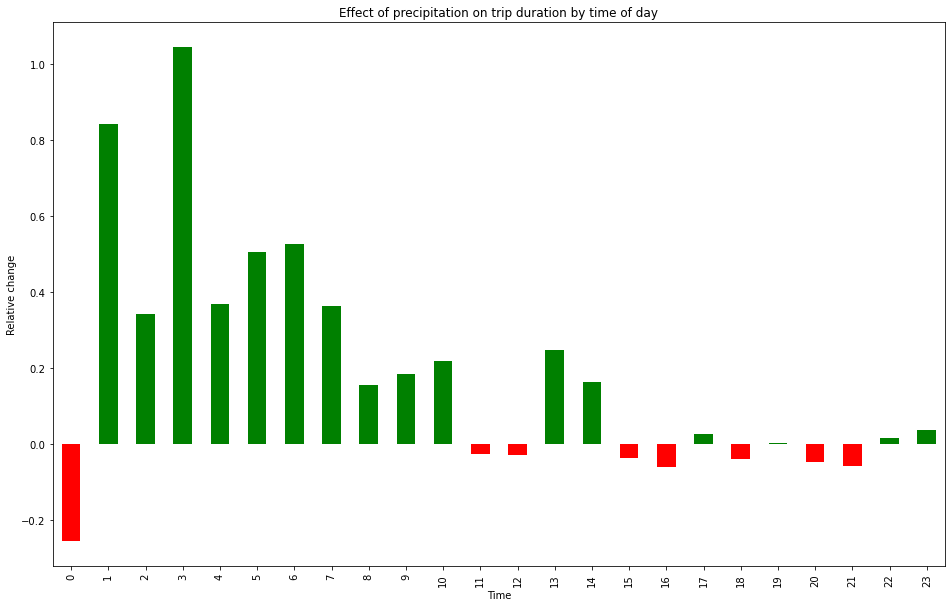

In [19]:
df = trip_df[['hour', 'duration', 'rain_flag']]
df.loc[:, 'rain_flag'] = (df['rain_flag'] > 0)*1
df = df.groupby(['hour', 'rain_flag']).mean().unstack()
df = (df.iloc[:, 1] - df.iloc[:, 0])/df.iloc[:, 0]
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Effect of precipitation on trip duration by time of day')
df.plot(ax=ax, kind='bar', color=(df > 0).map({True: 'green', False: 'red'}))
ax.set_xlabel('Time')
ax.set_ylabel('Relative change')
plt.show()


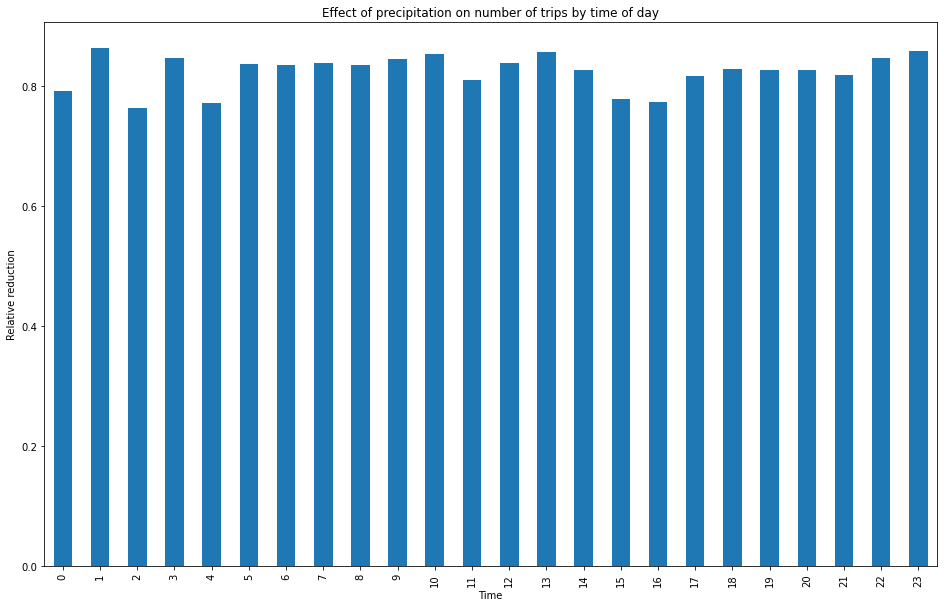

In [20]:
df = trip_df[['hour', 'bike_id', 'rain_flag']]
df.loc[:, 'rain_flag'] = (df['rain_flag'] > 0)*1
df = df.groupby(['hour', 'rain_flag']).count().unstack()
df = (df.iloc[:, 0] - df.iloc[:, 1])/df.iloc[:, 0]
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Effect of precipitation on number of trips by time of day')
df.plot(ax=ax, kind='bar')
ax.set_xlabel('Time')
ax.set_ylabel('Relative reduction')
plt.show()


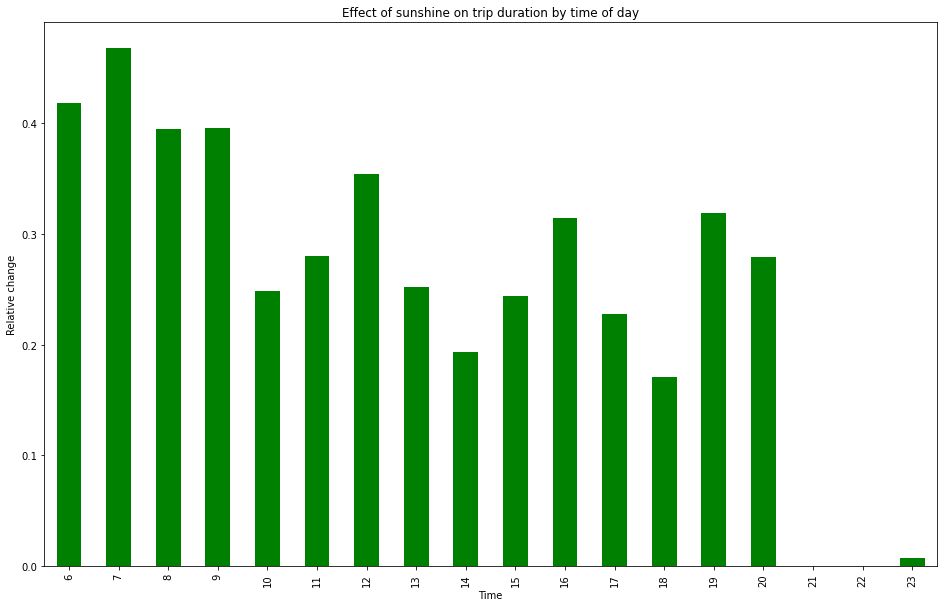

In [21]:
df = trip_df[['hour', 'duration', 'sun']]
df.loc[:, 'sun'] = (df['sun'] > 0)*1
df = df[df['hour'] > 5]
df = df.groupby(['hour', 'sun']).mean().unstack()
df = (df.iloc[:, 1] - df.iloc[:, 0])/df.iloc[:, 0]
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Effect of sunshine on trip duration by time of day')
df.plot(ax=ax, kind='bar', color=(df > 0).map({True: 'green', False: 'red'}))
ax.set_xlabel('Time')
ax.set_ylabel('Relative change')
plt.show()


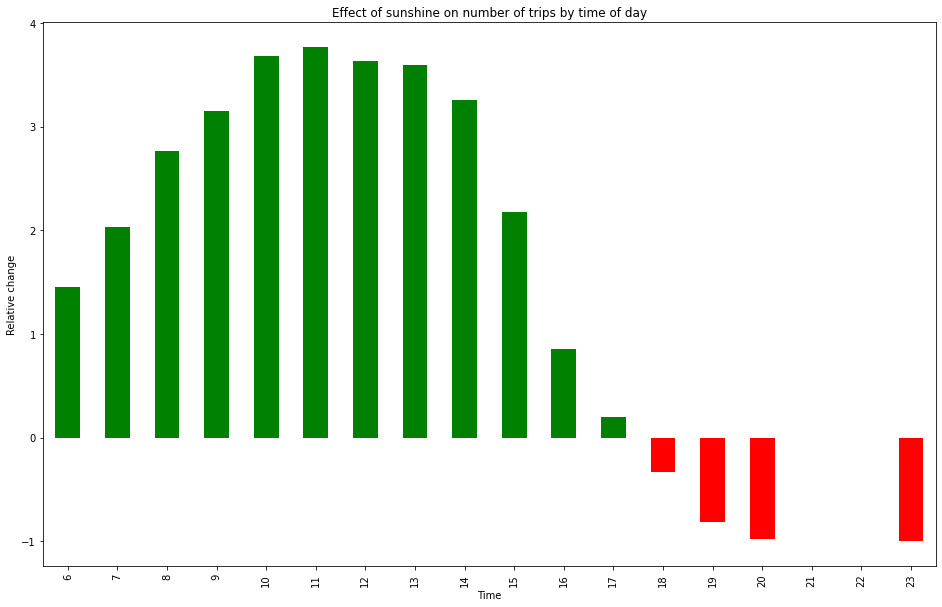

In [22]:
df = trip_df[['hour', 'bike_id', 'sun']]
df.loc[:, 'sun'] = (df['sun'] > 0)*1
df = df[df['hour'] > 5]
df = df.groupby(['hour', 'sun']).count().unstack()
df = (df.iloc[:, 1] - df.iloc[:, 0])/df.iloc[:, 0]
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Effect of sunshine on number of trips by time of day')
df.plot(ax=ax, kind='bar', color=(df > 0).map({True: 'green', False: 'red'}))
ax.set_xlabel('Time')
ax.set_ylabel('Relative change')
plt.show()


# Spatial analysis

### Heatmap of main stations

In [23]:
# Station dataset creation
stations_trip = bike_df[['p_lat', 'p_lng', 'p_name', 'trip']]
# dismiss data where 'trip' is in ['first', 'last']
stations_trip = stations_trip[stations_trip['trip'].isin(['start', 'end'])]
stations_df = stations_trip.drop_duplicates(['p_name'])
stations_df.head()


p_lat      p_lng                    p_name   trip
1   51.033548  13.748800          Strehlener Platz  start
2   51.058771  13.769281           Gutenbergstraße    end
4   51.067153  13.776480           Waldschlösschen    end
11  51.070350  13.729830  Alexander-Puschkin-Platz  start
12  51.051378  13.720459                BIKE 93025    end

In [24]:
df1 = trip_df.groupby(['start_lng', 'start_lat'])
s_start = df1.size()


In [25]:
df2 = trip_df.groupby(['end_lng', 'end_lat'])
s_end = df2.size()


In [26]:
s_start.head()


start_lng  start_lat
13.470018  51.163387    1
13.470691  51.163307    1
13.472072  51.167902    1
13.472608  51.163618    1
13.473570  51.163916    1
dtype: int64

In [27]:
index_start_0 = list()
index_start_1 = list()
index_end_0 = list()
index_end_1 = list()
for i in s_start.index:
    index_start_0.append(i[0])
    index_start_1.append(i[1])

for j in s_end.index:
    index_end_0.append(j[0])
    index_end_1.append(j[1])


In [28]:
# merge dataframe
df_start = pd.DataFrame(
    {'p_lng': index_start_0, 'p_lat': index_start_1, 'start_count': s_start.values})
df_end = pd.DataFrame(
    {'p_lng': index_end_0, 'p_lat': index_end_1, 'end_count': s_end.values})
stations_df = pd.merge(stations_df, df_start, how='left')
stations_df = pd.merge(stations_df, df_end, how='left')
#stations_df = stations_df.drop('trip',1)
stations_df = stations_df.dropna(axis=0, how='any')
stations_df.head()


p_lat      p_lng                       p_name   trip  start_count  \
0  51.033548  13.748800             Strehlener Platz  start         29.0   
1  51.058771  13.769281              Gutenbergstraße    end        964.0   
2  51.067153  13.776480              Waldschlösschen    end        432.0   
3  51.070350  13.729830     Alexander-Puschkin-Platz  start       2882.0   
6  51.068905  13.758976  Bischofsweg / Kamenzer Str.    end        608.0   

   end_count  
0       25.0  
1      908.0  
2      430.0  
3     2744.0  
6      550.0

In [29]:
# calculate attributes for each station
station_bike_ava = bike_df.groupby('p_name')['p_bikes'].mean().reset_index()
station_start_dura = trip_df.groupby(['start_lng', 'start_lat'])[
    'duration'].mean().reset_index()
station_start_dura = station_start_dura.rename(
    columns={'start_lng': 'p_lng', 'start_lat': 'p_lat', 'duration': 'start_duration'})
station_end_dura = trip_df.groupby(['end_lng', 'end_lat'])[
    'duration'].mean().reset_index()
station_end_dura = station_end_dura.rename(
    columns={'end_lng': 'p_lng', 'end_lat': 'p_lat', 'duration': 'end_duration'})
station_start_time = trip_df.groupby(['start_lng', 'start_lat'])[
    'hour'].mean().reset_index()
station_start_time = station_start_time.rename(
    columns={'start_lng': 'p_lng', 'start_lat': 'p_lat', 'hour': 'start_hour'})
station_end_time = trip_df.groupby(['end_lng', 'end_lat'])[
    'hour'].mean().reset_index()
station_end_time = station_end_time.rename(
    columns={'end_lng': 'p_lng', 'end_lat': 'p_lat', 'hour': 'end_hour'})


In [30]:
stations_df = pd.merge(stations_df, station_bike_ava, how='left')
stations_df = pd.merge(stations_df, station_start_dura, how='left')
stations_df = pd.merge(stations_df, station_start_time, how='left')
stations_df = pd.merge(stations_df, station_end_dura, how='left')
stations_df = pd.merge(stations_df, station_end_time, how='left')
stations_df


p_lat      p_lng                       p_name   trip  start_count  \
0    51.033548  13.748800             Strehlener Platz  start         29.0   
1    51.058771  13.769281              Gutenbergstraße    end        964.0   
2    51.067153  13.776480              Waldschlösschen    end        432.0   
3    51.070350  13.729830     Alexander-Puschkin-Platz  start       2882.0   
4    51.068905  13.758976  Bischofsweg / Kamenzer Str.    end        608.0   
..         ...        ...                          ...    ...          ...   
305  51.031061  13.727304         MOBIpunkt TU Dresden    end         98.0   
306  51.028201  13.760086          MOBIpunkt Wasaplatz  start        138.0   
307  51.057915  13.745714        MOBIpunkt Carolaplatz    end         47.0   
308  51.030110  13.727546                Hettnerstraße    end        118.0   
309  51.043537  13.703979            Tharandter Straße    end        231.0   

     end_count   p_bikes  start_duration  start_hour  end_duration   end_hour  
0         25.0  2.220183       46.689655   12.655172     28.960000  11.840000  
1        908.0  5.249423       27.098548   11.896266     28.292952  14.349119  
2        430.0  3.298362       25.289352   13.326389     27.904651  12.872093  
3       2744.0  4.823684       30.816794   12.884802     30.162536  14.378280  
4        550.0  4.204718       25.006579   11.394737     24.141818  14.929091  
..         ...       ...             ...         ...           ...        ...  
305       81.0  5.011765       12.408163   14.153061     17.074074  13.234568  
306      132.0  4.525862       17.594203   13.007246     20.128788  13.780303  
307       40.0  1.631579       22.680851   13.319149      9.125000  12.875000  
308      102.0  1.347222       13.923729   12.771186     11.196078  11.549020  
309      209.0  2.712500       20.991342   13.090909     14.162679  14.358852  

[310 rows x 11 columns]

##### Reason for only take large sites, small parking spots too large randomness.

### Heaxgons


In [31]:
# drop extrme stations
stations_df = stations_df[stations_df['p_lng'] > 13]


In [32]:
# Get the hexagon for a data point
# Assume we have a dataframe with a column for latitude and longitude representing "point data".
import pandas as pd
from shapely.geometry.polygon import Polygon
import h3
import geopandas

H3_HEXAGON_RESOLUTION = 8

stations_df["h3_hex_id"] = stations_df.apply(lambda row: h3.geo_to_h3(
    row["p_lat"], row["p_lng"], H3_HEXAGON_RESOLUTION) if (row['p_lat'] and row['p_lng']) else 0, axis=1)

trips_hex = stations_df
trips_hex['geometry'] = trips_hex.apply(lambda x: Polygon(
    h3.h3_to_geo_boundary(x["h3_hex_id"], geo_json=True)), axis=1)

print(trips_hex)


         p_lat      p_lng                       p_name   trip  start_count  \
0    51.033548  13.748800             Strehlener Platz  start         29.0   
1    51.058771  13.769281              Gutenbergstraße    end        964.0   
2    51.067153  13.776480              Waldschlösschen    end        432.0   
3    51.070350  13.729830     Alexander-Puschkin-Platz  start       2882.0   
4    51.068905  13.758976  Bischofsweg / Kamenzer Str.    end        608.0   
..         ...        ...                          ...    ...          ...   
305  51.031061  13.727304         MOBIpunkt TU Dresden    end         98.0   
306  51.028201  13.760086          MOBIpunkt Wasaplatz  start        138.0   
307  51.057915  13.745714        MOBIpunkt Carolaplatz    end         47.0   
308  51.030110  13.727546                Hettnerstraße    end        118.0   
309  51.043537  13.703979            Tharandter Straße    end        231.0   

     end_count   p_bikes  start_duration  start_hour  end_durat

<AxesSubplot:title={'center':'Spatial Vis of Trip_start'}>

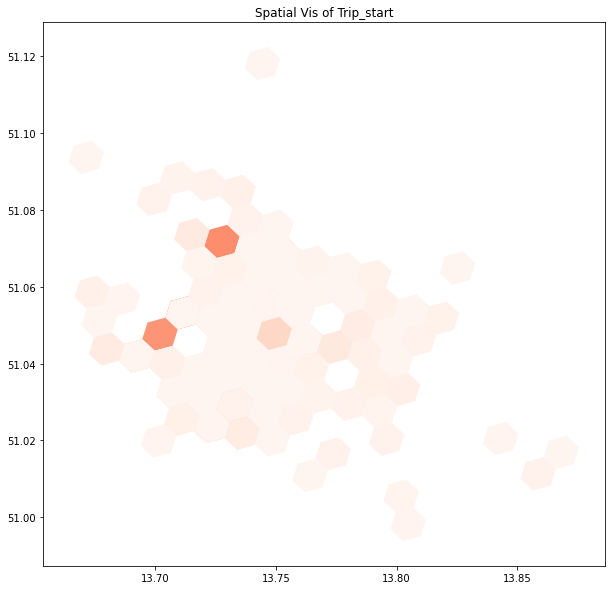

In [33]:
# Spatial Vis of Trip_start
trips_geo = geopandas.GeoDataFrame(
    trips_hex, geometry=trips_hex['geometry'], crs='EPSG:4326')
fig1, ax1 = plt.subplots(figsize=(16, 10))
ax1.set_title('Spatial Vis of Trip_start')

trips_geo.plot(column='start_count', cmap='Reds', ax=ax1)


<AxesSubplot:title={'center':'Spatial Vis of Trip_end'}>

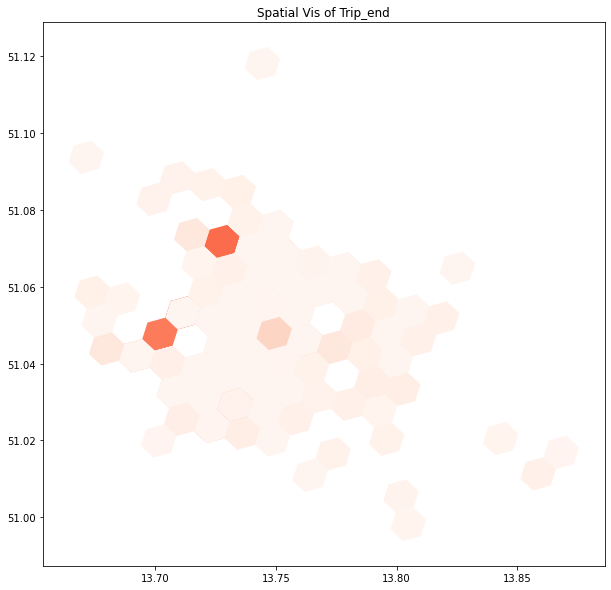

In [34]:
# Spatial Vis of Trip_end
fig2, ax2 = plt.subplots(figsize=(16, 10))
ax2.set_title('Spatial Vis of Trip_end')
trips_geo.plot(column='end_count', cmap='Reds', ax=ax2)


<AxesSubplot:title={'center':'Spatial Vis of Bike Availability'}>

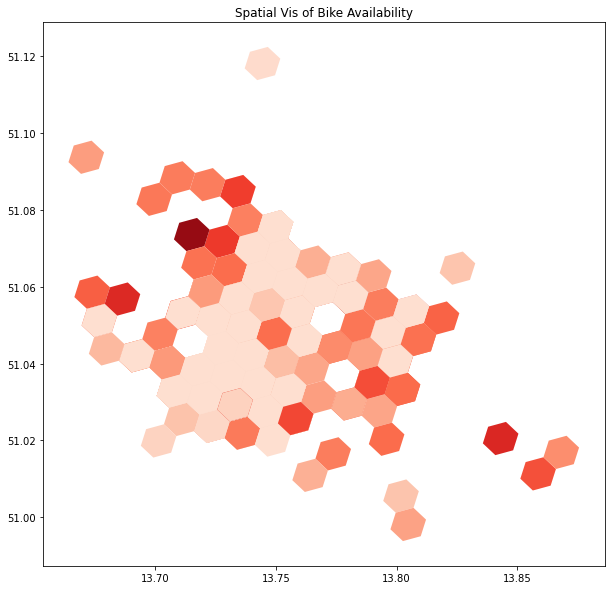

In [35]:
# Spatial Vis of Bike Availability
fig3, ax3 = plt.subplots(figsize=(16, 10))
ax3.set_title('Spatial Vis of Bike Availability')
trips_geo.plot(column='p_bikes', cmap='Reds', ax=ax3)


<AxesSubplot:title={'center':'Spatial Vis of duration by differnt start station'}>

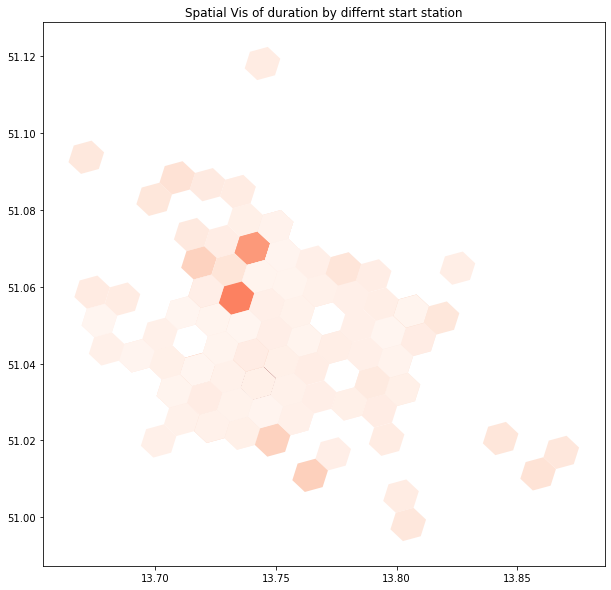

In [36]:
# Spatial Vis of duration by differnt start station
fig4, ax4 = plt.subplots(figsize=(16, 10))
ax4.set_title('Spatial Vis of duration by differnt start station')
trips_geo.plot(column='start_duration', cmap='Reds', ax=ax4)


<AxesSubplot:title={'center':'Spatial Vis of duration by differnt end station'}>

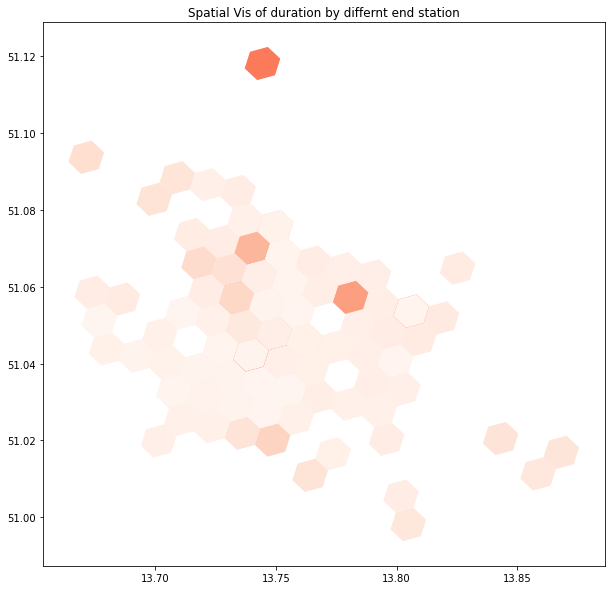

In [37]:
# Spatial Vis of duration by differnt end station
fig5, ax5 = plt.subplots(figsize=(16, 10))
ax5.set_title('Spatial Vis of duration by differnt end station')
trips_geo.plot(column='end_duration', cmap='Reds', ax=ax5)


<AxesSubplot:title={'center':'Spatial Vis of start time by differnt start station'}>

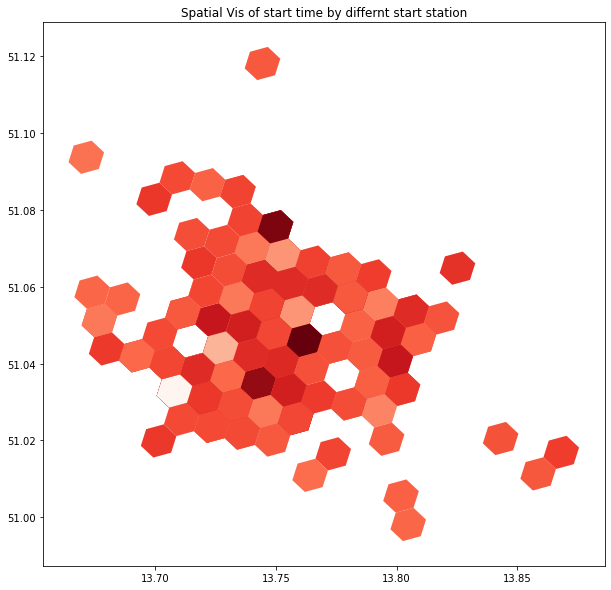

In [38]:
# Spatial Vis of start time by differnt start station
fig6, ax6 = plt.subplots(figsize=(16, 10))
ax6.set_title('Spatial Vis of start time by differnt start station')
trips_geo.plot(column='start_hour', cmap='Reds', ax=ax6)


<AxesSubplot:title={'center':'Spatial Vis of end time by differnt end station'}>

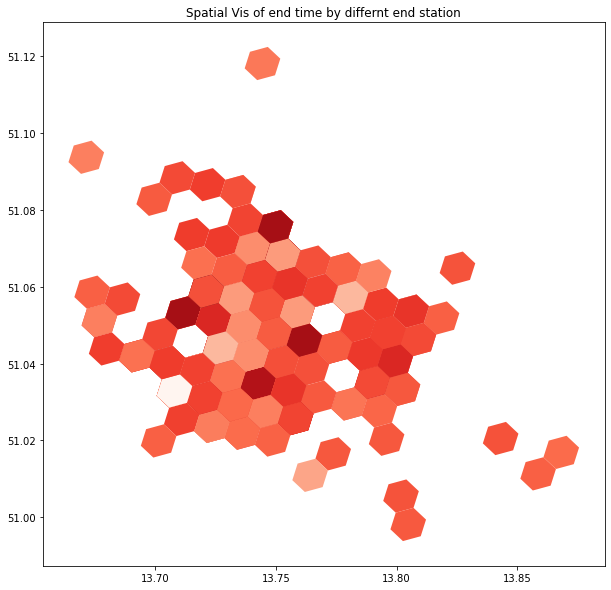

In [39]:
# Spatial Vis of end time by differnt end station
fig7, ax7 = plt.subplots(figsize=(16, 10))
ax7.set_title('Spatial Vis of end time by differnt end station')
trips_geo.plot(column='end_hour', cmap='Reds', ax=ax7)


#### Conclusion: 
       1. Except for a small number of areas, the number of bikes in other areas is positively correlated with the number of trips starting and ending in the area (the bikes in a few areas may be brought there and no longer used, which is accumulated over time)
       2. The central area has fewer stops and fewer vehicles, so people take longer to travel when starting and ending at these points(from other areas).
       3. The average travel start and end times of different stops have no obvious characteristics.

### Network on Map

In [40]:
station_trip_times = trip_df.groupby(['start_lng', 'start_lat', 'end_lng', 'end_lat'])[
    'start_time'].count().reset_index().rename(columns={'start_time': 'trip_count'})
station_trip_times = station_trip_times[station_trip_times['start_lng'] > 13]
station_trip_times = station_trip_times[station_trip_times['end_lng'] > 13]
station_trip_times


start_lng  start_lat    end_lng    end_lat  trip_count
0       13.470018  51.163387  13.713382  51.080258           1
1       13.470691  51.163307  13.713726  51.080071           1
2       13.472072  51.167902  13.749260  51.030220           1
3       13.472608  51.163618  13.733624  51.040476           1
4       13.473570  51.163916  13.681734  51.059955           1
...           ...        ...        ...        ...         ...
274777  14.078638  50.956240  13.717646  51.077480           1
274778  14.078738  50.956787  14.078738  50.956787           1
274779  14.079096  50.956964  13.738548  51.043724           1
274780  14.081174  50.958244  13.939561  50.964200           1
274781  14.147443  50.918538  13.731376  51.047284           1

[274782 rows x 5 columns]

In [41]:
# Graph with edge(trip----use times to represent degree of thickness) and Vertex(station-----use bike_availability to represent the radius of circle)
import folium
import webbrowser as wb
from folium.plugins import HeatMap, MiniMap, MarkerCluster
import numpy as np

map = folium.Map([51.06, 13.68],  # 地图中心
                 tiles='stamentoner',  # stamentoner,Stamen Watercolor,OpenStreetMap'
                 zoom_start=14)


def draw_CircleMarker(loc, radius, map):
    folium.CircleMarker(
        location=loc,
        radius=radius*3,
        color="blue",
        stroke=False,
        fill=True,
        fill_opacity=0.6,
        opacity=1,
        popup="{} bike_nummers".format(radius),
        tooltip=str(loc),
    ).add_to(map)


def draw_line(map, loc1, loc2, thick):
    kw = {"opacity": 1.0, "weight": thick/100}
    folium.PolyLine(
        smooth_factor=10,
        locations=[loc1, loc2],
        color="red",
        tooltip="trip_counts: {}".format(thick),
        **kw,
    ).add_to(map)


for tup in zip(stations_df['p_lat'], stations_df['p_lng'], stations_df['p_bikes']):
    draw_CircleMarker([tup[0], tup[1]], tup[2], map)


for rows in zip(station_trip_times['start_lat'], station_trip_times['start_lng'], station_trip_times['end_lat'], station_trip_times['end_lng'], station_trip_times['trip_count']):
    if rows[4] >= 4:
        draw_line(map, [rows[0], rows[1]], [rows[2], rows[3]], rows[4])

map.save('m.html')
wb.open('m.html')


True